In [1]:
import pandas
pandas.__version__

'0.20.3'

In [2]:
import sys
sys.path.append('I:/YaoTony/code/x8313')
from datetime import date
import pytest
from pandas import date_range
from horse.betsim.wrap.jcapper import JCapper
from horse.betsim.math import compute_probs_from_odds

In [3]:
# load JCapper Breeders Cup Results file
jcp = JCapper(verbose=True)
jcp.load(date_range(date(2017, 7, 3), date(2017, 7, 9)))
jcp.add_computed_columns()
print('load_jcapper: loaded %d rows' % (len(jcp.df)))

jcapper.load(2017-07-03)
jcapper.load(2017-07-04)
jcapper.load(2017-07-05)
jcapper.load(2017-07-06)
jcapper.load(2017-07-07)
jcapper.load(2017-07-08)
jcapper.load(2017-07-09)
JCapper.load() filtering scratched horses reduced from 9447 to 8500


/Users/saleemhuda/projects/x8313/horse/betsim/wrap/jcapper.py:273: RuntimeWarning: invalid value encountered in log
  self.df['log_ratio_effectivestarters_morningline'] = -1.0 * log(self.df.num_effective_starters_morning_line / self.df.num_starters)


load_jcapper: loaded 8500 rows


In [4]:
dfpay = jcp.df_payout.copy() #exotic bets payouts in easier form
dfres = jcp.df.copy() #race results dataframe

In [5]:
def compute_simple_payout(df, attr_model, ascending=False, bet_amount=1.0):
    """
    Add columns for quick calculation of Win bets % payout
    :param df: Dataframe from dataset for multiple races
    :param attr_model: (string)an attribute / prob or score in the dataframe that can be ranked
    :param ascending: False if best is higher score i.e. probs
    :param bet_amount: default to 1.0
    :return: Dataframe with columns added

    """
    df['is_win'] = df['official_finish_position'].map(lambda x:int(x==1))
    df['rank_' + attr_model] = df.groupby('race_id')[attr_model].transform(lambda x:x.rank(ascending=False))
    df['bet_amount'] = df['rank_' + attr_model].map(lambda x:int(x<1.5)*bet_amount)
    df['is_wager'] = df['bet_amount'].map(lambda x:int(x>0))
    df['is_paid'] = df['is_wager'] * df['is_win']
    df['payout'] = df['is_win']*df['bet_amount']*df['payout_win'].fillna(0.0)

    return df

In [6]:
def compute_advantage(df):

    pct_win = df.groupby('race_id')['is_paid'].sum().value_counts(normalize=True)[1]

    pct_loss = 1.0 - pct_win
    mean_odds = df[df.is_paid>0]['final_tote_odds'].mean()
    advantage = pct_win - pct_loss / mean_odds
    print(advantage)
    return advantage

In [7]:
attr_bench_final = 'prob_final_tote_odds'
dfresnew = compute_simple_payout(dfres, attr_model=attr_bench_final, ascending=False, bet_amount=1.0)

In [8]:
advantage_final = compute_advantage(dfresnew)# attr_model= attr_bench_final, ascending=False,bet_amount=1.0)

-0.17148271984334124


In [9]:
#'diff_abs_logprob_final_tote_morning_line' is like log-return of one runner, we wanted to get 'sum return', so we weighted 'diff_abs_logprob_final_tote_morning_line' and got the sum of abs.
dfres['diff_abs_logprob_final_tote_morning_line'] = abs(dfres['diff_logprob_final_tote_morning_line']/dfres['num_starters'])
dfres['diff_sum_logprob_final_tote_morning_line'] = dfres.groupby('race_id')['diff_abs_logprob_final_tote_morning_line'].transform(lambda x:sum(x))
dfres.head()

,chart_file_sym,date,race_number,breed_code,distance,is_about_distance,surface_code,is_off_turf,course_type_code,race_type_code,...,max_prob_morning_line_odds,max_prob_final_tote_odds,underperformance_weighted,is_win,bet_amount,is_wager,is_paid,payout,diff_abs_logprob_final_tote_morning_line,diff_sum_logprob_final_tote_morning_line
0,AP,2017-07-03,1,TB,7.0,0,P,0,M,MCL,...,0.364803,0.343878,0.000000,1,1.0,1,1,4.8,0.057891,0.356776
1,AP,2017-07-03,1,TB,7.0,0,P,0,M,MCL,...,0.364803,0.343878,0.000000,0,0.0,0,0,0.0,0.019873,0.356776
2,AP,2017-07-03,1,TB,7.0,0,P,0,M,MCL,...,0.364803,0.343878,0.086874,0,0.0,0,0,0.0,0.078462,0.356776
3,AP,2017-07-03,1,TB,7.0,0,P,0,M,MCL,...,0.364803,0.343878,0.073688,0,0.0,0,0,0.0,0.044076,0.356776
4,AP,2017-07-03,1,TB,7.0,0,P,0,M,MCL,...,0.364803,0.343878,-0.253941,0,0.0,0,0,0.0,0.019873,0.356776


In [10]:
#we just keep the most favourate runner's data in each race
dfres_fav = dfres.loc[dfres['rank_prob_final_tote_odds']==1]
dfres_fav = dfres_fav.reset_index(drop=True)

In [11]:
#in the following analysis, we want to find relationship of 'underperformance_weighted' and 3 variables: 'diff_logprob_final_tote_morning_line', 'diff_sum_logprob_final_tote_morning_line','num_starters' 

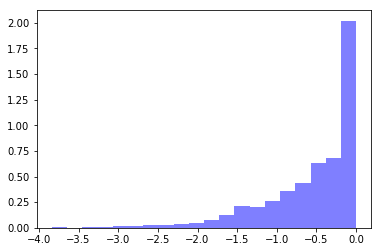

In [12]:
import matplotlib.pyplot as plt
#histogram of 'underperformance_weighted'
import matplotlib.mlab as mlab
num_bins = 20
n, bins, patches = plt.hist(dfres_fav['underperformance_weighted'], num_bins, normed=1, facecolor='blue', alpha=0.5)
plt.show()

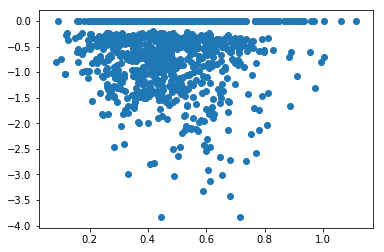

In [13]:
plt.scatter(dfres_fav['diff_sum_logprob_final_tote_morning_line'],dfres_fav['underperformance_weighted'])
plt.show()
#no obvious relationship found

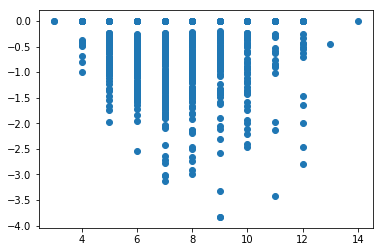

In [14]:
plt.scatter(dfres_fav['num_starters'],dfres_fav['underperformance_weighted'])
plt.show()
#no obvious relationship found

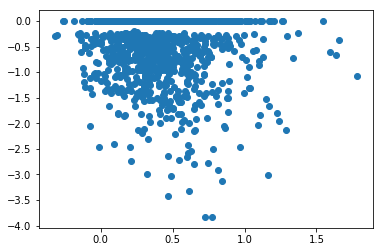

In [15]:
plt.scatter(dfres_fav['diff_logprob_final_tote_morning_line'],dfres_fav['underperformance_weighted'])
plt.show()
#no obvious relationship found

In [16]:
#linear regression
import statsmodels.formula.api as sm
result = sm.ols(formula="underperformance_weighted ~ diff_logprob_final_tote_morning_line + num_starters+diff_sum_logprob_final_tote_morning_line", data=dfres_fav).fit()

In [17]:
result.params

Intercept                                  -0.305578
diff_logprob_final_tote_morning_line       -0.141737
num_starters                               -0.041581
diff_sum_logprob_final_tote_morning_line    0.281288
dtype: float64

In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     underperformance_weighted   R-squared:                       0.015
Model:                                   OLS   Adj. R-squared:                  0.012
Method:                        Least Squares   F-statistic:                     5.579
Date:                       Thu, 21 Jun 2018   Prob (F-statistic):           0.000846
Time:                               16:29:21   Log-Likelihood:                -1069.3
No. Observations:                       1115   AIC:                             2147.
Df Residuals:                           1111   BIC:                             2167.
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.3056      0.090     -3.401      0.001      -0.482      -0.129
diff_logprob_final_tote_morning_line        -0.1417      0.079     -1.790      0.074      -0.297       0.014
num_starters                                -0.0416      0.012     -3.604      0.000      -0.064      -0.019
diff_sum_logprob_final_tote_morning_line     0.2813      0.137      2.057      0.040       0.013       0.550
==============================================================================
Omnibus:                      314.468   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              770.449
Skew:                          -1.505   Prob(JB):                    5.00e-168
Kurtosis:                       5.743   Cond. No.                         59.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
#find quantiles of 'underperformance_weighted' to set classes
quantile = dfres_fav['underperformance_weighted'].quantile([.2, .4, .6, .8])
dfres_fav['underperformance_class'] = 4
dfres_fav.loc[dfres_fav['underperformance_weighted'] < quantile[.8],'underperformance_class'] = 3
dfres_fav.loc[dfres_fav['underperformance_weighted'] < quantile[.6],'underperformance_class'] = 2
dfres_fav.loc[dfres_fav['underperformance_weighted'] < quantile[.4],'underperformance_class'] = 1
dfres_fav.loc[dfres_fav['underperformance_weighted'] < quantile[.2],'underperformance_class'] = 0

In [20]:
#just keep useful columns
dfres_fav_1 = dfres_fav[['diff_logprob_final_tote_morning_line','diff_sum_logprob_final_tote_morning_line', 'num_starters','underperformance_weighted', 'underperformance_class']]
dfres_fav_1.head()

,diff_logprob_final_tote_morning_line,diff_sum_logprob_final_tote_morning_line,num_starters,underperformance_weighted,underperformance_class
0,0.405235,0.356776,7,0.000000,4
1,0.068782,0.236487,6,-1.415755,0
2,0.198876,0.401806,6,-1.224550,0
3,0.043925,0.380867,7,0.000000,4
4,0.253792,0.357477,8,-0.582042,1


In [21]:
#drop rows with na values
dfres_fav_1 = dfres_fav_1.dropna(axis=0, how='any')
dfres_fav_1=dfres_fav_1.reset_index(drop=True)

In [22]:
#doing random forest
from sklearn.ensemble import RandomForestClassifier
nrow = dfres_fav_1.shape[0]
ntrain = int(nrow/5*4)
dfres_fav_train, dfres_fav_test = dfres_fav_1.iloc[0:ntrain,:], dfres_fav_1.iloc[ntrain:nrow,:]

In [23]:
import pandas as pd
features = dfres_fav_1.columns[:3]
#y = pd.factorize(dfres_fav_train['underperformance_class'])[0]
y = dfres_fav_train['underperformance_class']
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(dfres_fav_train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [24]:
# Apply the Classifier we trained to the test data (which, remember, it has never seen before)
preds = clf.predict(dfres_fav_test[features])
clf.predict_proba(dfres_fav_test[features])[0:10]


array([[0.6, 0. , 0.2, 0. , 0.2],
       [0.3, 0.1, 0.4, 0. , 0.2],
       [0.1, 0.4, 0.4, 0. , 0.1],
       [0. , 0.1, 0.5, 0. , 0.4],
       [0.4, 0.1, 0. , 0. , 0.5],
       [0. , 0.3, 0.3, 0. , 0.4],
       [0.1, 0.3, 0.1, 0. , 0.5],
       [0. , 0. , 0.6, 0. , 0.4],
       [0.2, 0.1, 0. , 0. , 0.7],
       [0.2, 0.3, 0.2, 0. , 0.3]])

In [25]:
# Create confusion matrix
pd.crosstab(dfres_fav_test['underperformance_class'], preds, rownames=['Actual class'], colnames=['Predicted class'])
#result is not good

Predicted class,0,1,2,3,4
Actual class,,,,,
0,10,9,7,2,15
1,8,11,6,0,22
2,9,8,10,0,14
3,1,0,0,0,0
4,20,22,11,1,37


In [26]:
# View a list of the features and their importance scores
list(zip(dfres_fav_train[features], clf.feature_importances_))

[('diff_logprob_final_tote_morning_line', 0.4638679874424462),
 ('diff_sum_logprob_final_tote_morning_line', 0.4427258003580724),
 ('num_starters', 0.09340621219948149)]